In [65]:
import pickle
import sys
import spike.spike_analysis.wilcoxon as wilcox
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
import importlib
import spike.spike_analysis.spike_recording as rec
import plotly.graph_objects as go
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    


In [2]:
novel_collection = unpickle_this('novel_collection.pkl')
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection.analyze(timebin = 50, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 50, ignore_freq=0.5)



All set to analyze


KeyboardInterrupt: 

# Neurons per recording

In [12]:
total_neurons = 0
total_good_neurons = 0
for recording in cagemate_collection.collection: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.5:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

134 164


In [13]:
total_neurons = 0
total_good_neurons = 0
for recording in novel_collection.collection: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.5:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

131 145


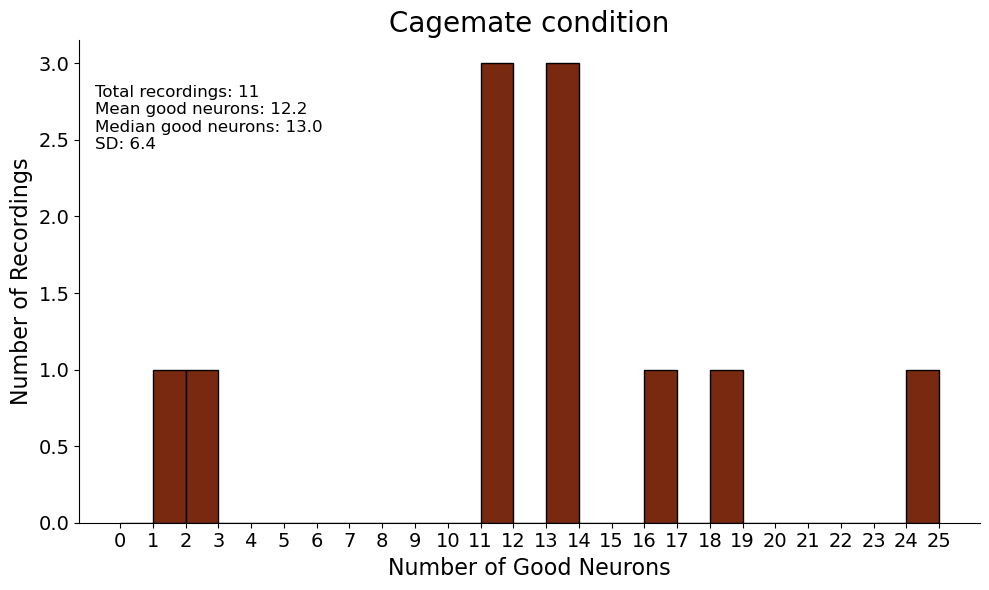

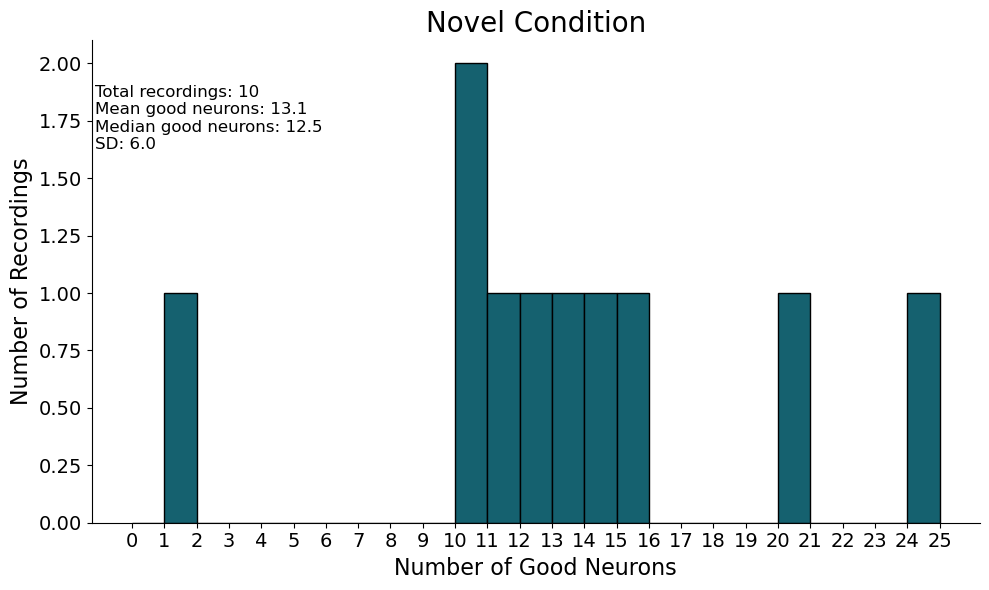

In [14]:
def plot_neuron_histogram(collection, title, color, bin_size=5):
   # Get counts of good neurons per recording
    recording_data = []

    for recording in collection.collection:
        total = len(recording.freq_dict.keys())
        good = sum(1 for freq in recording.freq_dict.values() if freq > 0.5)
        recording_data.append({
            'recording': recording.name,
            'total_neurons': total,
            'good_neurons': good
        })

    # Create DataFrame
    df = pd.DataFrame(recording_data)
   
    # Create histogram
    plt.figure(figsize=(10, 6))

    # Calculate number of bins based on bin_size
    bins = np.arange(0, max(df['good_neurons']) + bin_size, bin_size)

    plt.hist(df['good_neurons'], bins=bins, color=color, edgecolor='black')

    # Customize plot
    plt.xlabel('Number of Good Neurons', fontsize=16)
    plt.ylabel('Number of Recordings', fontsize=16)
    plt.title(f'{title}', fontsize=20)

    # Set ticks
    plt.xticks(bins, fontsize=14)
    plt.yticks(fontsize=14)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add summary statistics as text
    plt.figtext(0.1, 0.85, 
                f'Total recordings: {len(df["good_neurons"])}\n'
                f'Mean good neurons: {np.mean(df["good_neurons"]):.1f}\n'
                f'Median good neurons: {np.median(df["good_neurons"]):.1f}\n'
                f'SD: {np.std(df["good_neurons"]):.1f}',
                fontsize=12, ha='left', va='top')

    plt.tight_layout()
    plt.show()

    return df

# Usage:
good_counts = plot_neuron_histogram(cagemate_collection, title = 'Cagemate condition', color = '#792910', bin_size=1)
good_counts_novel = plot_neuron_histogram(novel_collection, title = 'Novel Condition', color = '#15616F', bin_size = 1)

In [15]:
good_counts

,recording,total_neurons,good_neurons
0,11_cage_p1_merged.rec,19,13
1,12_cage_p1_merged.rec,24,18
2,13_cage_p1_merged.rec,14,11
3,21_cage_p1_merged.rec,33,25
4,22_cage_p1_merged.rec,13,13
5,24_cage_p1_merged.rec,12,11
6,31_cage_p1_merged.rec,1,1
7,32_cage_p1_merged.rec,15,13
8,33_cage_p1_merged.rec,2,2
9,41_cage_p1_merged.rec,15,11


In [16]:
good_counts_novel

,recording,total_neurons,good_neurons
0,11_nov_p1_merged.rec,21,20
1,12_nov_p1_merged.rec,21,15
2,13_nov_p1_merged.rec,11,11
3,21_nov_p1_merged.rec,10,10
4,22_nov_p1_merged.rec,12,12
5,24_nov_p1_merged.rec,12,10
6,32_nov_p1_merged.rec,13,13
7,33_nov_p1_merged.rec,1,1
8,41_nov_p1_merged.rec,27,25
9,44_nov_p1_merged.rec,17,14


# Wilcoxon: Presniff vs Sniff

In [18]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 2
offset = 1
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1': 4.5, 'exp4':2.5, 'exp5': 4}
events = ['exp1', 'exp4', 'exp5']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_collection(cagemate_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset=True, plot=False)
novel_merged = wilcox.wilcoxon_collection(novel_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset = True, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_collection(cagemate_collection, event=event, event_length=cagemate_event_length, baseline_window=baseline_window, offset=offset, plot=False)
   novel_df = wilcox.wilcoxon_collection(novel_collection, event=event, event_length=novel_event_length_dict[event], baseline_window=baseline_window, offset=offset, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec exp1, because <6 samples
Wilcoxon can't be done on 33_cage_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 44_cage_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 12_nov_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 11_cage_p1_merged.rec exp5, because <6 samples


In [19]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
0,201,not significant,not significant,not significant
1,125,increases,not significant,not significant
2,210,not significant,not significant,not significant
3,268,increases,increases,not significant
4,9,not significant,not significant,increases
...,...,...,...,...
111,123,not significant,not significant,not significant
112,98,not significant,not significant,not significant
113,190,not significant,not significant,not significant
114,133,not significant,not significant,not significant


In [20]:

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_17644\2812253529.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
cell group,,,,
,98,98,98,98
exp1,6,6,6,6
exp1exp4,1,1,1,1
exp1exp5,1,1,1,1
exp4,2,2,2,2
exp5,8,8,8,8


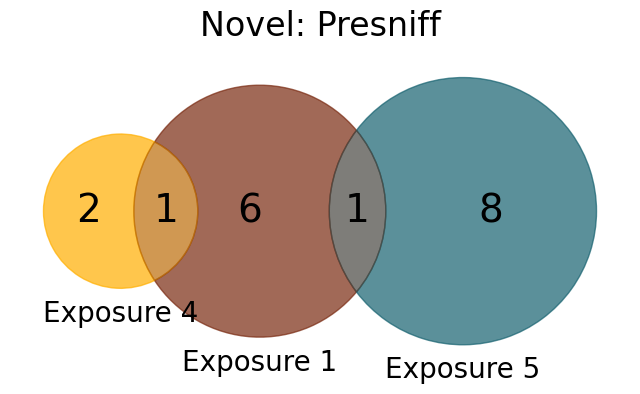

In [ ]:
set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Presniff', fontsize =24)
plt.show()

In [22]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
0,40,not significant,not significant,not significant
1,1,not significant,not significant,not significant
2,209,not significant,not significant,not significant
3,263,not significant,not significant,not significant
4,350,not significant,not significant,not significant
...,...,...,...,...
98,34,not significant,not significant,not significant
99,42,not significant,not significant,not significant
100,18,not significant,not significant,not significant
101,50,not significant,not significant,not significant


In [23]:
cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_17644\3783352757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
cell group,,,,
,83,83,83,83
exp1,3,3,3,3
exp4,10,10,10,10
exp5,7,7,7,7


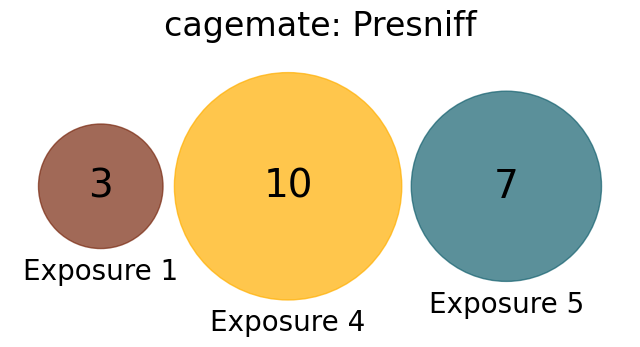

In [24]:
set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('cagemate: Presniff', fontsize =24)
plt.show()

# Wilcoxon: Baseline vs Sniff

In [40]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 2
offset = 0
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1': 4.5, 'exp4':2.5, 'exp5': 4}
events = ['exp1', 'exp4', 'exp5']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)
novel_merged = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=event, event2 = 'baseline', event_length=cagemate_event_length, pre_window = 0, plot=False)
   novel_df = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=event, event2 = 'baseline', event_length=novel_event_length_dict[event], pre_window = 0, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp1 or baseline
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 44_cage_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 12_nov_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 11_cage_p1_merged.rec because <6 samples for either exp5 or baseline


C:\Users\megha\AppData\Local\Temp\ipykernel_54932\371303454.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


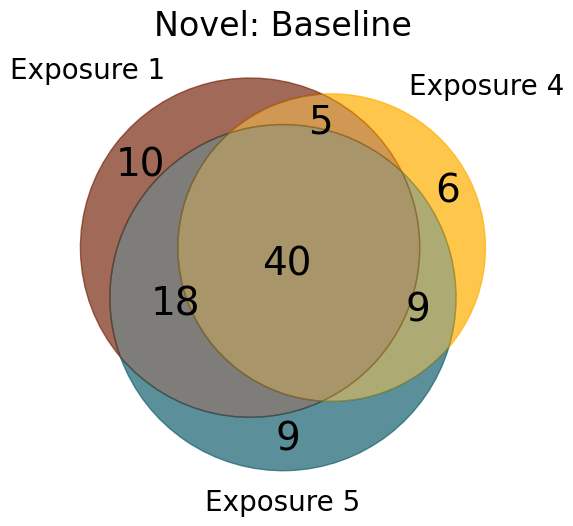

In [43]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Baseline', fontsize =24)
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_54932\2359003080.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


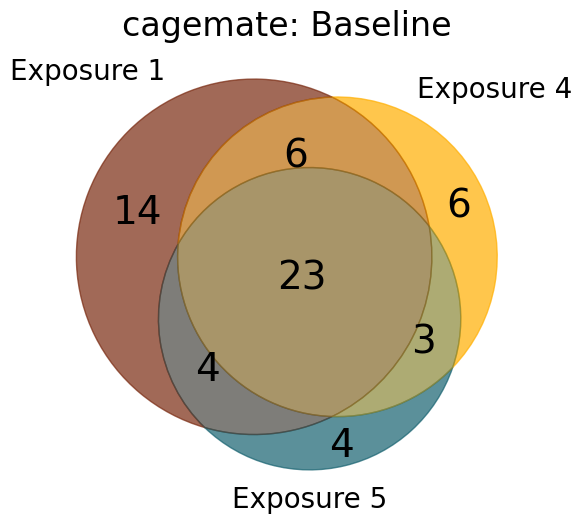

In [44]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('cagemate: Baseline', fontsize =24)
plt.show()

# auROC

In [52]:
# from importlib import reload
# reload(wilcox)

# cagemate_collection.analyze(timebin = 100, ignore_freq= 0.5)
# bootstrap_results = wilcox.bootstrap(cagemate_collection, ['exp1', 'exp4', 'exp5'], 3, pre_window = 0, num_perm = 2000)

All set to analyze


In [46]:
from importlib import reload
reload(wilcox)

novel_collection.analyze(timebin = 100, ignore_freq= 0.5)
bootstrap_results = wilcox.bootstrap(novel_collection, ['exp1', 'exp4', 'exp5'], 3, pre_window = 0, num_perm = 2000)

All set to analyze


In [47]:
bootstrap_results.to_csv('bootstrap_exp1_4_5_novel.csv')

In [55]:
bootstrap_results_novel = pd.read_csv('bootstrap_exp1_4_5_novel.csv')

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5,cell group
0,0,9,11_nov_p1_merged.rec,significantly increased,significantly increased,significantly increased,
1,1,127,11_nov_p1_merged.rec,significantly increased,significantly decreased,significantly decreased,
2,2,210,11_nov_p1_merged.rec,not significantly changed,significantly decreased,not significantly changed,
3,3,251,11_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased,
4,4,8,11_nov_p1_merged.rec,significantly decreased,not significantly changed,significantly decreased,
...,...,...,...,...,...,...,...
126,126,98,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased,
127,127,123,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased,
128,128,190,44_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased,
129,129,130,44_nov_p1_merged.rec,not significantly changed,significantly increased,significantly increased,


In [4]:


def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'significantly increased') or (exp1 == 'significantly decreased'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'significantly increased') or (exp4 == 'significantly decreased'):
        group = group + 'exp4'
    if (exp5 == 'significantly increased') or (exp5 == 'significantly decreased'):
        group = group + 'exp5'
    return group

bootstrap_results['cell group'] = bootstrap_results.apply(lambda row: group_cells(row['exp1'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4'],
                                                                  row['exp5']), axis = 1)
results = bootstrap_results.groupby('cell group').count()
results



,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5
cell group,,,,,,
,15,15,15,15,15,15
exp1,10,10,10,10,10,10
exp1exp4,14,14,14,14,14,14
exp1exp4exp5,32,32,32,32,32,32
exp1exp5,23,23,23,23,23,23
exp4,9,9,9,9,9,9
exp4exp5,23,23,23,23,23,23
exp5,8,8,8,8,8,8


In [56]:
bootstrap_results_novel

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5
0,0,9,11_nov_p1_merged.rec,significantly increased,significantly increased,significantly increased
1,1,127,11_nov_p1_merged.rec,significantly increased,significantly decreased,significantly decreased
2,2,210,11_nov_p1_merged.rec,not significantly changed,significantly decreased,not significantly changed
3,3,251,11_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased
4,4,8,11_nov_p1_merged.rec,significantly decreased,not significantly changed,significantly decreased
...,...,...,...,...,...,...
126,126,98,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased
127,127,123,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased
128,128,190,44_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased
129,129,130,44_nov_p1_merged.rec,not significantly changed,significantly increased,significantly increased


In [57]:
def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'significantly increased') or (exp1 == 'significantly decreased'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'significantly increased') or (exp4 == 'significantly decreased'):
        group = group + 'exp4'
    if (exp5 == 'significantly increased') or (exp5 == 'significantly decreased'):
        group = group + 'exp5'
    return group

In [58]:
bootstrap_results_novel['cell group'] = bootstrap_results_novel.apply(lambda row: group_cells(row['exp1'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4'],
                                                                  row['exp5']), axis = 1)
results_novel = bootstrap_results_novel.groupby('cell group').count()
results_novel

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5
cell group,,,,,,
,9,9,9,9,9,9
exp1,8,8,8,8,8,8
exp1exp4,10,10,10,10,10,10
exp1exp4exp5,55,55,55,55,55,55
exp1exp5,18,18,18,18,18,18
exp4,4,4,4,4,4,4
exp4exp5,18,18,18,18,18,18
exp5,9,9,9,9,9,9


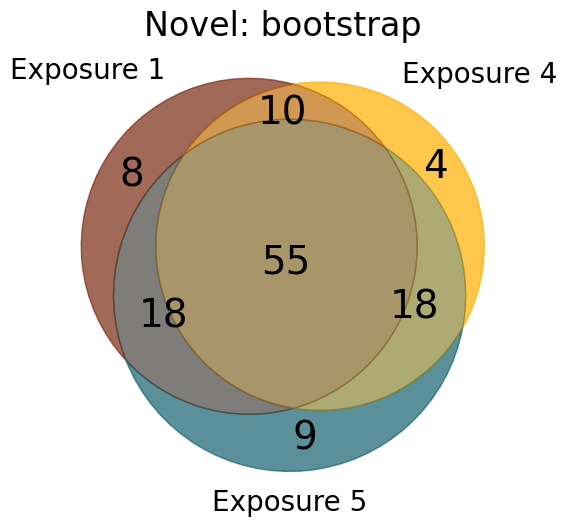

In [60]:
set1 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp1')])
set2 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp4')])
set3 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: bootstrap', fontsize =24)
plt.show()

In [61]:
bootstrap_results_novel

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5,cell group
0,0,9,11_nov_p1_merged.rec,significantly increased,significantly increased,significantly increased,exp1exp4exp5
1,1,127,11_nov_p1_merged.rec,significantly increased,significantly decreased,significantly decreased,exp1exp4exp5
2,2,210,11_nov_p1_merged.rec,not significantly changed,significantly decreased,not significantly changed,exp4
3,3,251,11_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased,exp1exp4exp5
4,4,8,11_nov_p1_merged.rec,significantly decreased,not significantly changed,significantly decreased,exp1exp5
...,...,...,...,...,...,...,...
126,126,98,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased,exp1exp4exp5
127,127,123,44_nov_p1_merged.rec,significantly decreased,significantly increased,significantly increased,exp1exp4exp5
128,128,190,44_nov_p1_merged.rec,significantly decreased,significantly decreased,significantly decreased,exp1exp4exp5
129,129,130,44_nov_p1_merged.rec,not significantly changed,significantly increased,significantly increased,exp4exp5


In [66]:
#values = exp1 increase - exp4 increase , exp1 increase - exp4 decrease , exp1 increase - exp4 no change
values = []
meaning = []
for exposure in ['exp1', 'exp4']:
    for conditionA in ["significantly increased", "significantly decreased", "not significantly changed"]:
        temp = bootstrap_results_novel[bootstrap_results_novel[exposure] == conditionA]
        for conditionB in ["significantly increased", "significantly decreased", "not significantly changed"]:
            if exposure == 'exp1':
                values.append(int(temp['exp4'].value_counts()[conditionB]))
                meaning.append(exposure + conditionA + 'exp4' + conditionB) 
            if exposure == 'exp4':
                values.append(temp['exp5'].value_counts()[conditionB])
                meaning.append(exposure + conditionA + 'exp5' + conditionB) 
print(values)
print(meaning)

[7, 15, 12, 27, 16, 14, 12, 10, 18, np.int64(29), np.int64(8), np.int64(9), np.int64(7), np.int64(29), np.int64(5), np.int64(10), np.int64(17), np.int64(17)]
['exp1significantly increasedexp4significantly increased', 'exp1significantly increasedexp4significantly decreased', 'exp1significantly increasedexp4not significantly changed', 'exp1significantly decreasedexp4significantly increased', 'exp1significantly decreasedexp4significantly decreased', 'exp1significantly decreasedexp4not significantly changed', 'exp1not significantly changedexp4significantly increased', 'exp1not significantly changedexp4significantly decreased', 'exp1not significantly changedexp4not significantly changed', 'exp4significantly increasedexp5significantly increased', 'exp4significantly increasedexp5significantly decreased', 'exp4significantly increasedexp5not significantly changed', 'exp4significantly decreasedexp5significantly increased', 'exp4significantly decreasedexp5significantly decreased', 'exp4significan

In [106]:
names = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
targets = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change",
                "significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
color_dict = {'increased':'red','decreased':'blue','change':'grey'}
color_dict_links = {"increased":"#FFDCDC", 'decreased': "#DCE5FF", 'change':  "#DBDBDB"}
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = names,             # Third stage
        pad = 15,
        thickness = 20,
        color = [color_dict[x.split(' ')[-1]] for x in names],
         y = [0.15, 0.49, 0.85,     # First stage (A_1, B_1, C_1)
            0.18, 0.51, 0.84,     # Second stage (A_2, B_2, C_2) 
            0.18, 0.55, 0.88],    # Third stage (A_3, B_3, C_3)
       # x positions to space out stages
        x = [0.1, 0.1, 0.1,       # First stage
            0.5, 0.5, 0.5,       # Second stage
            0.9, 0.9, 0.9] 
    ),
    link = dict(
        # First stage to second stage
        source = [0, 0, 0,          # Math101 to Pass/Fail
                 1, 1, 1,
                 2, 2, 2,
                 3, 3, 3, 
                 4, 4, 4, 
                 5, 5, 5],          # Physics101 to Pass/Fail
        target = [3, 4, 5,          # to Pass Math/Fail Math
                 3, 4, 5,
                 3, 4, 5,
                 6, 7, 8,
                 6, 7, 8,
                 6, 7, 8],          # to Pass Physics/Fail Physics
        value = values,  
        color = [color_dict_links[x.split(' ')[-1]] for x in targets],
         
      
               # 70 pass physics, 30 fail
    )
)])
fig.update_layout(
    annotations=[
        # First group title
        dict(
            x=-0.05,  # x position (0 to 1)
            y=1.1,  # y position above the plot
            xref="paper",
            yref="paper",
            text="Exposure 1",
            showarrow=False,
            font=dict(size=16)
        ),
        # Second group title
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 4",
            showarrow=False,
            font=dict(size=16)
        ),
        # Third group title
        dict(
            x=1.05,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 5",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            x=.5,
            y=1.3,
            xref="paper",
            yref="paper",
            text="Novel",
            showarrow=False,
            font=dict(size=24)
        )
    ],
    # Add more top margin to make room for labels
    margin=dict(t=100)
)

fig.show()

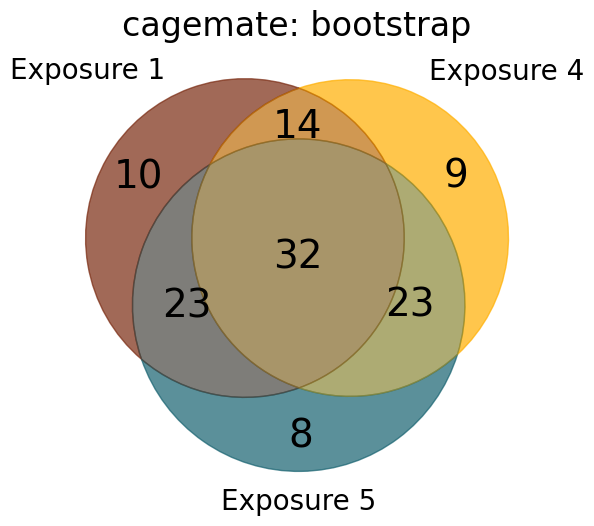

In [5]:
set1 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp1')])
set2 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp4')])
set3 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('cagemate: bootstrap', fontsize =24)
plt.show()

In [17]:
bootstrap_results[bootstrap_results['exp4'] == 'not significantly changed']

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5,cell group
4,4,61,11_cage_p1_merged.rec,signifcantly increased,not significantly changed,signifcantly decreased,exp1exp5
7,7,108,11_cage_p1_merged.rec,signifcantly increased,not significantly changed,signifcantly increased,exp1exp5
8,8,163,11_cage_p1_merged.rec,signifcantly decreased,not significantly changed,signifcantly increased,exp1exp5
10,10,233,11_cage_p1_merged.rec,not significantly changed,not significantly changed,not significantly changed,
12,12,107,11_cage_p1_merged.rec,signifcantly increased,not significantly changed,signifcantly increased,exp1exp5
13,13,245,12_cage_p1_merged.rec,not significantly changed,not significantly changed,not significantly changed,
14,14,345,12_cage_p1_merged.rec,signifcantly decreased,not significantly changed,not significantly changed,exp1
15,15,350,12_cage_p1_merged.rec,not significantly changed,not significantly changed,not significantly changed,
19,19,365,12_cage_p1_merged.rec,not significantly changed,not significantly changed,not significantly changed,
20,20,263,12_cage_p1_merged.rec,signifcantly decreased,not significantly changed,signifcantly decreased,exp1exp5


In [92]:
names = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
targets = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change",
                "significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
color_dict = {'increased':'red','decreased':'blue','change':'grey'}
color_dict_links = {"increased":"#FFDCDC", 'decreased': "#DCE5FF", 'change':  "#DBDBDB"}
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = names,             # Third stage
        pad = 15,
        thickness = 20,
        color = [color_dict[x.split(' ')[-1]] for x in names] ,
        y = [0.15, 0.45, 0.82,     # First stage (A_1, B_1, C_1)
            0.15, 0.45, 0.82,     # Second stage (A_2, B_2, C_2) 
            0.185, 0.52, 0.85],    # Third stage (A_3, B_3, C_3)
       # x positions to space out stages
        x = [0.1, 0.1, 0.1,       # First stage
            0.5, 0.5, 0.5,       # Second stage
            0.9, 0.9, 0.9] 
    ),
    link = dict(
        # First stage to second stage
        source = [0, 0, 0,          # Math101 to Pass/Fail
                 1, 1, 1,
                 2, 2, 2,
                 3, 3, 3, 
                 4, 4, 4, 
                 5, 5, 5],          # Physics101 to Pass/Fail
        target = [3, 4, 5,          # to Pass Math/Fail Math
                 3, 4, 5,
                 3, 4, 5,
                 6, 7, 8,
                 6, 7, 8,
                 6, 7, 8],          # to Pass Physics/Fail Physics
        value = [15, 3, 18,        # 80 pass math, 20 fail
                12, 16, 15,         #sig inc, sig dec, no change
                12, 20, 23,
                25, 3, 11,
                6, 21, 12,
                18, 13, 25],  
        color = [color_dict_links[x.split(' ')[-1]] for x in targets],
        
      
               # 70 pass physics, 30 fail
    )
)])
fig.update_layout(
    annotations=[
        # First group title
        dict(
            x=-0.05,  # x position (0 to 1)
            y=1.1,  # y position above the plot
            xref="paper",
            yref="paper",
            text="Exposure 1",
            showarrow=False,
            font=dict(size=16)
        ),
        # Second group title
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 4",
            showarrow=False,
            font=dict(size=16)
        ),
        # Third group title
        dict(
            x=1.05,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 5",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            x=.5,
            y=1.3,
            xref="paper",
            yref="paper",
            text="Cagemate",
            showarrow=False,
            font=dict(size=24)
        )
    ],
    # Add more top margin to make room for labels
    margin=dict(t=100)
)

fig.show()

In [8]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = ["A_1", "B_1",           # First stage
                "A_2", "B_2",            # Second stage
                "A_3", "B_3"],           # Third stage
        # You can customize how they display
        customdata = ["A", "B",          # What you actually want to show
                     "A", "B",
                     "A", "B"],
        # Use hovertemplate to show the customdata instead of the internal labels
        hovertemplate='%{customdata}<br />Value: %{value}<extra></extra>',
        pad = 15,
        thickness = 20,
    ),
    link = dict(
        source = [0, 0, 1, 1,        # First to second stage (A_1->A_2/B_2, B_1->A_2/B_2)
                 2, 2, 3, 3],        # Second to third stage (A_2->A_3/B_3, B_2->A_3/B_3)
        target = [2, 3, 2, 3,        # To second stage
                 4, 5, 4, 5],        # To third stage
        value = [80, 20, 70, 30,     # First to second flows
                75, 5, 65, 25]       # Second to third flows
    )
)])

fig.update_layout(title_text="Alluvial Diagram with Repeated Labels")
fig.show()

In [14]:
import plotly.graph_objects as go

# fig = go.Figure(data=[go.Sankey(
#     node = dict(
#         label = ["Math101", "Physics101",           # First stage
#                 "Pass Math", "Fail Math",           # Second stage
#                 "Pass Physics", "Fail Physics",     
#                 "Graduate", "Dropout"],             # Third stage
#         pad = 15,
#         thickness = 20,
#     ),
#     link = dict(
#         # First stage to second stage
#         source = [0, 0,          # Math101 to Pass/Fail
#                  1, 1],          # Physics101 to Pass/Fail
#         target = [2, 3,          # to Pass Math/Fail Math
#                  4, 5],          # to Pass Physics/Fail Physics
#         value = [80, 20,         # 80 pass math, 20 fail
#                 70, 30],         # 70 pass physics, 30 fail
#     )
# )])

# You can also add flows from second stage to third stage:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = ["Math101", "Physics101", 
                "Pass Math", "Fail Math", "Pass Physics", "Fail Physics",
                "Graduate", "Dropout"],
        pad = 15,
        thickness = 20,
    ),
    link = dict(
        source = [0, 0, 1, 1,        # First to second stage
                 2, 3, 4, 5],        # Second to third stage
        target = [2, 3, 4, 5,        # To second stage
                 6, 7, 6, 7],        # To third stage
        value = [80, 20, 70, 30,     # First to second flows
                75, 5, 65, 25]       # Second to third flows
    )
)])

fig.show()